# NFL 2018 Defense Analyzer

# Importing Libraries

In [24]:
# acquire libraries
import pandas as pd
import matplotlib.pyplot as plt

#explore libraries
from scipy import stats
import seaborn as sns
import prep_plays
plt.rc("figure", figsize=(12, 7))
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split

# model libraries
import wrangle_plays_data
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option('display.max_columns', None)

Wrangle.py Loaded Successfully


# Acquire 

- We acquired the data from kaggle.com as several .csv's but the data itself is provided by nextgenstats.nfl.com

In [ ]:
nfl = pd.read_csv('plays.csv')

In [ ]:
nfl.head()

In [ ]:
nfl.shape

In [ ]:
nfl.info()

In [ ]:
nfl.describe().T

In [ ]:
num_cols = nfl.columns[[(nfl[col].dtype == 'int64') | (nfl[col].dtype == 'float64') for col in nfl.columns]]
for col in num_cols:
    plt.hist(nfl[col])
    plt.title(col)
    plt.show()

**Takeaways:**
- There are some null values listed that will need some investigation
- more plays are being ran in the second and forth quarted
- less plays are being ran as the down gets greater
- yards to go is skewed right(makes sense)
    - less likely to lose yards than gain
- most plays begin between home 20 and away 20
    - hard to pin your opponent inside 20 for kickoff or punt
- defenders in the box is a normal distribution
- number of pass  rushers is a normal distribution
- scores are skewed right
- play result is skewed right slightly
- epa is fairly normal distribution

# Prepare

- Create a function that will acquire the plays.csv
- Keep only the useful columns that can help us determine the success of a defense(whether a pass was completed or not)
    - `playDescription`, `quarter`, `down`, `yardsToGo`, `possessionTeam`, `offenseFormation`, `personnelO`, `defendersInTheBox`, `numberOfPassRushers`, `personnelD`, `typeDropback`, `gameClock`, `absoluteYardlineNumber`, `epa`, `playType`, `passResult`, `playResult`
- create a new column called `pass_stopped` 
    - will change completion into 0
    - will change incomplete and interception into 1
- filter out data that is not a pass play(no fake punts, fake field goals, etc)
- create new columns that extract positions from offensive personnel
    - RB, TE, WR
- Create new columns that extract positions from defensive personnel
    - DL, LB, DB
- rename `typeDropback` to `QB_under_pressure` and change values into normal or scramble
- rename `passResult` into `pass_stopped`
- create formations out of personnel on the field

# Explore

In [2]:
train, validate, test = prep_plays.explore_plays_data()

In [3]:
train

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,QB_under_pressure,gameClock,absoluteYardlineNumber,epa,playType,pass_stopped,playResult,RB,TE,WR,DL,LB,DB
16935,(1:55) (Shotgun) B.Gabbert pass short middle t...,3,3,7,TEN,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,4.0,"2 DL, 4 LB, 5 DB",0.0,01:55:00,47.0,1.782888,play_type_pass,0,14,1,1,3,2,4,5
5447,(7:31) (Shotgun) E.Manning pass short left to ...,3,2,9,NYG,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.0,07:31:00,73.0,-0.652451,play_type_pass,0,4,1,1,3,4,2,5
9559,(15:00) (Shotgun) P.Mahomes pass short right t...,4,1,10,KC,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,3.0,"4 DL, 2 LB, 5 DB",0.0,15:00:00,70.0,-0.243036,play_type_pass,0,4,1,1,3,4,2,5
8337,(9:24) (Shotgun) M.Trubisky pass incomplete de...,2,3,6,CHI,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,6.0,"3 DL, 3 LB, 5 DB",0.0,09:24:00,95.0,-1.337397,play_type_pass,1,0,1,1,3,3,3,5
2939,(3:51) (Shotgun) S.Bradford pass incomplete sh...,3,2,12,ARI,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.0,03:51:00,44.0,-0.918842,play_type_pass,1,0,1,1,3,4,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,(:19) (Shotgun) R.Fitzpatrick pass short middl...,1,3,2,TB,EMPTY,"1 RB, 1 TE, 3 WR",5.0,4.0,"4 DL, 2 LB, 5 DB",0.0,00:19:00,93.0,1.054657,play_type_pass,0,6,1,1,3,4,2,5
12282,(1:10) (Shotgun) J.Allen pass deep left to Z.J...,4,3,11,BUF,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,6.0,"4 DL, 2 LB, 5 DB",0.0,01:10:00,80.0,-0.707038,play_type_pass,1,0,1,1,3,4,2,5
1985,(9:59) (Shotgun) D.Prescott pass short middle ...,4,3,4,DAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,5.0,"1 DL, 5 LB, 5 DB",0.0,09:59:00,59.0,-1.344754,play_type_pass,0,3,2,1,2,1,5,5
14672,(9:04) (Shotgun) J.Johnson pass short right to...,3,3,10,WAS,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",0.0,09:04:00,84.0,1.426667,play_type_pass,0,11,1,1,3,4,2,5


## Does the offense formation matter? i.e. (is a certain offensive formation harder to defend?)

- $H_0$: There is no dependence between offensive formation and pass stopped
- $H_a$: There is a dependence between offensive formation and pass stopped

In [4]:
alpha = .05

In [5]:
observed = pd.crosstab(train.offenseFormation, train.pass_stopped)

In [6]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [7]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


0.019278800162284792

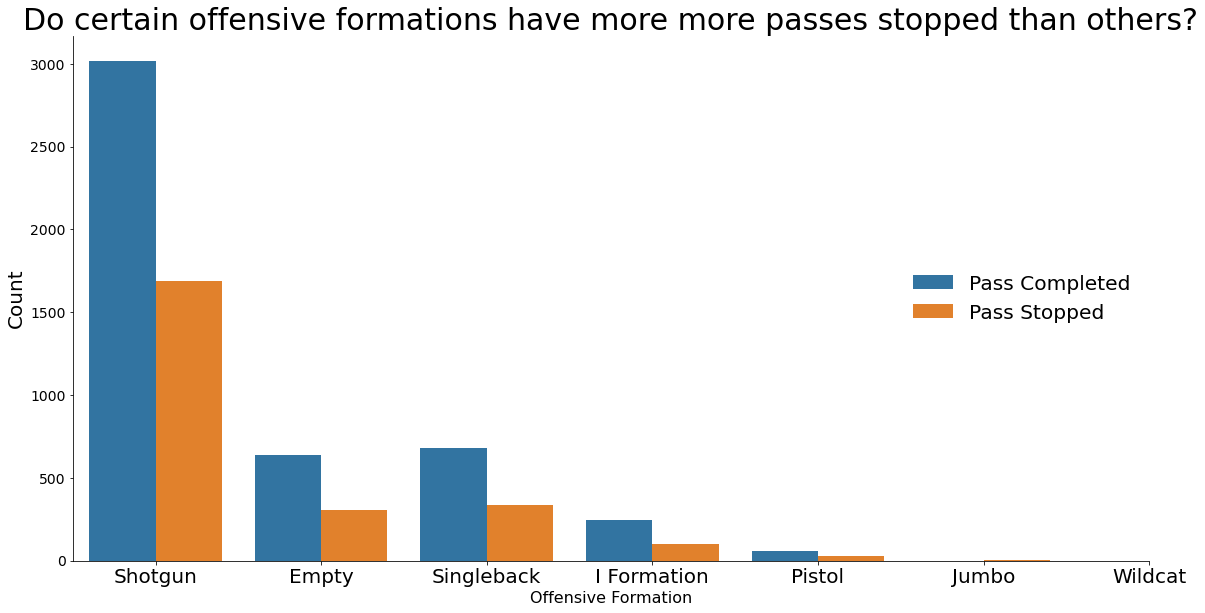

In [8]:
sns.catplot(x="offenseFormation", hue="pass_stopped", kind="count", data=train, height=8, aspect=2)._legend.remove()
plt.title('Do certain offensive formations have more more passes stopped than others?', size = 30)
plt.xlabel('Offensive Formation', size = 16)
plt.ylabel('Count', size = 20)
plt.legend(labels = ('Pass Completed', 'Pass Stopped'), loc='center right', frameon=False, fontsize='x-large')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Shotgun', 'Empty', 'Singleback', 'I Formation', 'Pistol', 'Jumbo', 'Wildcat'], size = 20)
plt.show()

**Takeaways:**
- There does not seem to be a certain formation that will have there pass stopped more than others
- After a statistical test, we can safely say that there is not dependence on stopping the play and the formation the offense is lined up in.

In [9]:
train.groupby('offenseFormation').pass_stopped.count()

offenseFormation
EMPTY          944
I_FORM         346
JUMBO            4
PISTOL          88
SHOTGUN       4704
SINGLEBACK    1022
Name: pass_stopped, dtype: int64

In [10]:
train[train.pass_stopped ==1].groupby('offenseFormation').pass_stopped.count()

offenseFormation
EMPTY          308
I_FORM         101
JUMBO            3
PISTOL          28
SHOTGUN       1687
SINGLEBACK     339
Name: pass_stopped, dtype: int64

## Are passes stoped dependent on Down?

- $H_0$: There is no dependence between down and pass stopped
- $H_a$: There is a dependence between down and pass stopped

In [11]:
observed = pd.crosstab(train.down, train.pass_stopped)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


2.24584723019191e-08

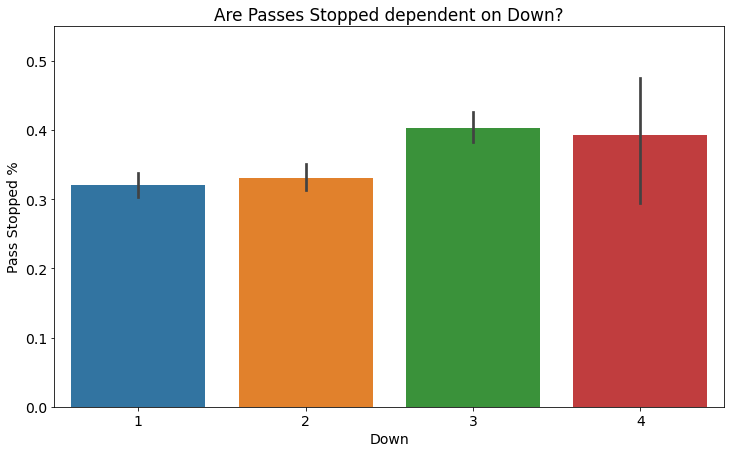

In [12]:
sns.barplot(data=train,x='down', y='pass_stopped').set(ylim=(0, .55))
plt.xlabel('Down')
plt.ylabel('Pass Stopped %')
plt.title("Are Passes Stopped dependent on Down?")
plt.show()

**Takeaway:**
- There is a dependence between a pass being stopped and what down it is.
- more passes are stopped on 3rd down with 4th down right behind it


In [13]:
train.groupby('down').pass_stopped.count()

down
1    2742
2    2393
3    1851
4     122
Name: pass_stopped, dtype: int64

In [14]:
train[train.pass_stopped ==1].groupby('down').pass_stopped.count()

down
1    879
2    792
3    747
4     48
Name: pass_stopped, dtype: int64

## Are passes stopped dependent on QB pressure?

- $H_0$: There is no dependence between QB pressure and pass stopped
- $H_a$: There is a dependence between QB pressure and pass stopped

In [15]:
observed = pd.crosstab(train.QB_under_pressure, train.pass_stopped)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


7.278509046599062e-24

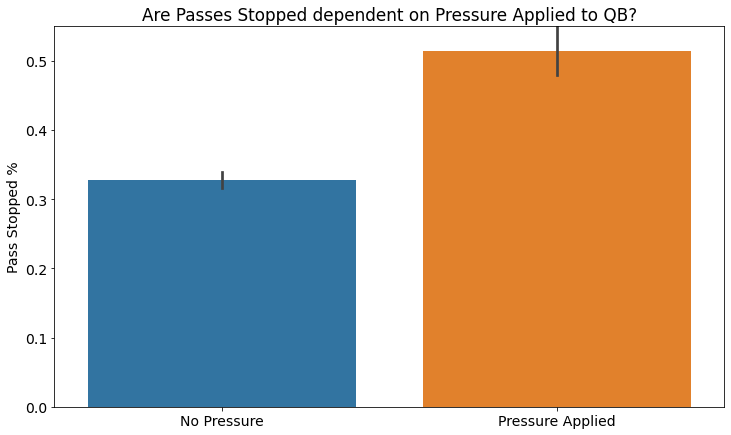

In [16]:
sns.barplot(data=train,x='QB_under_pressure', y='pass_stopped').set(ylim=(0, .55))
plt.xlabel('')
plt.ylabel('Pass Stopped %')
plt.xticks([0,1], ['No Pressure', 'Pressure Applied'])
plt.title("Are Passes Stopped dependent on Pressure Applied to QB?")
plt.show()

In [19]:
train.groupby('QB_under_pressure').pass_stopped.count()

QB_under_pressure
0.0    6372
1.0     736
Name: pass_stopped, dtype: int64

In [20]:
train[train.pass_stopped ==1].groupby('QB_under_pressure').pass_stopped.count()

QB_under_pressure
0.0    2087
1.0     379
Name: pass_stopped, dtype: int64

## Are passes stopped dependent on how many Defenders are in the Box?

- $H_0$: There is no dependence between defenders in the box and pass stopped
- $H_a$: There is a dependence between defenders in the box and pass stopped

In [18]:
observed = pd.crosstab(train.defendersInTheBox, train.pass_stopped)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We fail to reject the null hypothesis


0.19301408562843791

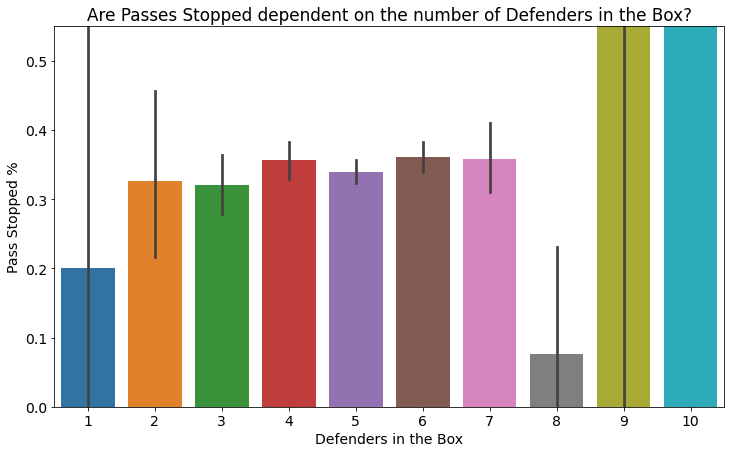

In [17]:
sns.barplot(data=train,x='defendersInTheBox', y='pass_stopped').set(ylim=(0, .55))
plt.xlabel('Defenders in the Box')
plt.ylabel('Pass Stopped %')
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
plt.title("Are Passes Stopped dependent on the number of Defenders in the Box?")
plt.show()

In [21]:
train.groupby('defendersInTheBox').pass_stopped.count()

defendersInTheBox
2.0        5
3.0       46
4.0      428
5.0     1265
6.0     3323
7.0     1653
8.0      371
9.0       13
10.0       3
11.0       1
Name: pass_stopped, dtype: int64

In [22]:
train[train.pass_stopped ==1].groupby('defendersInTheBox').pass_stopped.count()

defendersInTheBox
2.0        1
3.0       15
4.0      137
5.0      451
6.0     1128
7.0      597
8.0      133
9.0        1
10.0       2
11.0       1
Name: pass_stopped, dtype: int64

# Model

In [26]:
df = prep_plays.prep_plays_data()

In [28]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_plays_data.train_validate_test(df)

In [29]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_plays_data.min_max_scale(X_train, X_validate, X_test)

## Train

### Gradient Boost

In [30]:
boost_params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [31]:
ml = GridSearchCV(GradientBoostingClassifier(), boost_params, cv=5)
ml.fit(X_train_scaled, y_train)
print(ml.score(X_train_scaled, y_train))

0.8738095238095238


In [32]:
y_pred = ml.predict(X_train_scaled)

In [33]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred))
cm

,0,1
0,3958,684
1,217,2281


In [34]:
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
class_report

,0,1,accuracy,macro avg,weighted avg
precision,0.948024,0.769309,0.87381,0.858666,0.885499
recall,0.852650,0.913131,0.87381,0.882890,0.873810
f1-score,0.897811,0.835072,0.87381,0.866442,0.875861
support,4642.000000,2498.000000,0.87381,7140.000000,7140.000000


### KNN

### Logistic Regression

### Random Forest

## Validate

### Gradient Boost

In [36]:
print(ml.score(X_validate_scaled, y_validate))

0.8586134453781512


In [37]:
y_pred_val = ml.predict(X_validate_scaled)

In [38]:
cm = pd.DataFrame(confusion_matrix(y_pred_val, y_validate))
cm

,0,1
0,2568,146
1,527,1519


In [39]:
class_report = pd.DataFrame(classification_report(y_validate, y_pred_val, output_dict=True))
class_report

,0,1,accuracy,macro avg,weighted avg
precision,0.946205,0.742424,0.858613,0.844315,0.874924
recall,0.829725,0.912312,0.858613,0.871019,0.858613
f1-score,0.884145,0.818647,0.858613,0.851396,0.861235
support,3095.000000,1665.000000,0.858613,4760.000000,4760.000000


### KNN

### Logistic Regression

### Random Forest

## Test

# Conclusions / Next Steps